# Coupling pySDC to libraries for spatial discretization
pySDC is a library for time integration.
But we need something to integrate in the first place...
We can make life hard and code up some problem discretization from scratch yet again, or we use our time more efficiently by building on other peoples work.
This tutorial will show how to do the latter by coupling pySDC to Firedrake.
Coupling other libraries requires the same steps taken here.
If you are working with compiled code, keep in mind that Python is designed to work with compiled code and you can interface via well established frameworks such as [pybind11](https://github.com/pybind/pybind11) or [F2PY](https://numpy.org/doc/stable/f2py/index.html).

## What is Firedrake?
[Firedrake](https://www.firedrakeproject.org) is an elaborate framework for discretizing PDEs using the finite element method (FEM), sharing many characteristics with FEniCS.
Firedrake code looks a lot like mathematical equations, so once you have a PDE in weak form, it is easy to implement with Firedrake.
This is an immensely powerful tool for setting up complicated problems on complicated meshes while relying on a lot of existing automation rather than coding everything yourself.
For a few basic examples and explanations see the [Firedrake documentation](https://www.firedrakeproject.org/documentation.html).


## Installing Firedrake
Installing Firedrake can be non-trivial, but it keeps improving.
Please consult the respective [documentation](https://www.firedrakeproject.org/install.html#id9).
If you get stuck, open a discussion on the [GitHub page](https://github.com/firedrakeproject/firedrake/discussions), where the Firedrake developers are responsive and helpful.

To run this notebook, you need make a kernel with your Firedrake installation.
Activate a virtual environment with Firedrake installed, then install pySDC and jupyter stuff with
```
pip install -e <path-to-pySDC>
pip install ipykernel
pip install jupyter
pip install jdc
```

Afterwards, generate the kernel and start the notebook:
```
python -m ipykernel install --user --name=pySDC_Firedrake
python -m jupyter lab
```

## Coupling pySDC to Firedrake
pySDC is already coupled to Firedrake, so don't worry.
However, we will briefly go through the existing coupling here to illustrate how to couple pySDC to any library.
pySDC abstracts away specifics of the type of data is working with via a datatype interface and coupling to another library essentially means writing a datatype that connects pySDC and the library.
This datatype needs to respect only a few properties, have a rule for generating empty data containers, communication is also handled there.

With `u`, `v` data as used in the library you want to couple to and `a` a float, the following must hold:
 - `abs(u)` must return a float with the norm across the entire spatial domain
 - `a*u + v - v*u` must be implemented and the result must be of the same type as `u`.
  
For communication, the following functions familiar from MPI need implementing in the datatypes:
 - `bcast`: Broadcast data
 - `Isend`: Non-blocking send of the data
 - `Irecv`: Non-blocking receive of the data

Communication is only needed if you intend to actually run pySDC in parallel with a diagonal sweeper or PFASST.
You can always not implement any communication and run the parallel algorithms in serial.

So, coupling pySDC to a library typically means writing a wrapper for the data or subclassing the datatype and adding only the above mentioned functionality.

In the case of Firedrake, we write a wrapper for `Firedrake.Function` which we call `firedrake_mesh` here.
We start with the `__init__` function, which is called during object instantiation.
Here, we will make use of `__mro__`, which returns the [method resolution order](https://docs.python.org/3/howto/mro.html) of the object we call this on, which tells us the tree of inheritance relationships of the objects class.
The inheritance relationship we are looking for here depends on some intricacies of Firedrake that you needn't worry about now.

In [1]:
import jdc  # required to split the class definition into multiple cells...

import firedrake as fd

from pySDC.core.errors import DataError
from pySDC.helpers.firedrake_ensemble_communicator import FiredrakeEnsembleCommunicator


class firedrake_mesh(object):
    """
    Wrapper for firedrake function data.

    Attributes:
        functionspace (firedrake.Function): firedrake data
    """

    def __init__(self, init, val=0.0):
        # init tells us how to instantiate a new mesh
        if fd.functionspaceimpl.WithGeometry in type(init).__mro__:
            self.functionspace = fd.Function(init)
            self.functionspace.assign(val)
        elif fd.Function in type(init).__mro__:
            self.functionspace = fd.Function(init)
        elif type(init) == firedrake_mesh:
            self.functionspace = init.functionspace.copy(deepcopy=True)
        else:
            raise DataError('something went wrong during %s initialization' % type(init))

Next, we make this a wrapper for `firedrake.Function` via the `__getattr__` method.
If you call `a.key` on an object `a` and `a` does not have an attribute or function `key`, `a.__getattr__(key)` will be called, which makes it easy to pass on requests.

In [2]:
%%add_to firedrake_mesh

def __getattr__(self, key):
    return getattr(self.functionspace, key)

Next up, we define addition, subtraction and right mupltiplication for the new datatype:

In [3]:
%%add_to firedrake_mesh

def __add__(self, other):
    if isinstance(other, type(self)):
        me = firedrake_mesh(other)
        me.functionspace.assign(self.functionspace + other.functionspace)
        return me
    else:
        raise DataError("Type error: cannot add %s to %s" % (type(other), type(self)))

def __sub__(self, other):
    if isinstance(other, type(self)):
        me = firedrake_mesh(other)
        me.functionspace.assign(self.functionspace - other.functionspace)
        return me
    else:
        raise DataError("Type error: cannot add %s to %s" % (type(other), type(self)))

def __rmul__(self, other):
    """
    Overloading the right multiply by scalar factor

    Args:
        other (float): factor
    Raises:
        DataError: if other is not a float
    Returns:
        fenics_mesh: copy of original values scaled by factor
    """

    try:
        me = firedrake_mesh(self)
        me.functionspace.assign(other * self.functionspace)
        return me
    except TypeError as e:
        raise DataError("Type error: cannot multiply %s to %s" % (type(other), type(self))) from e

Now, we take care of the norm, which is as simple as calling a Firedrake function:

In [4]:
%%add_to firedrake_mesh

def __abs__(self):
    """
    Overloading the abs operator for mesh types

    Returns:
        float: L2 norm
    """

    return fd.norm(self.functionspace, 'L2')

Finally: Communication.
Firedrake has "ensemble communicators", which were built by Josh for space-time parallelism.
In pySDC, we have written a wrapper for them that makes a few things easier, but, essentially, communication is again handled using Firedrake functions.

In [5]:
%%add_to firedrake_mesh

def isend(self, dest=None, tag=None, comm=None):
    """
    Routine for sending data forward in time (non-blocking)

    Args:
        dest (int): target rank
        tag (int): communication tag
        comm: communicator

    Returns:
        request handle
    """
    assert (
        type(comm) == FiredrakeEnsembleCommunicator
    ), f'Need to give a FiredrakeEnsembleCommunicator here, not {type(comm)}'
    return comm.Isend(self.functionspace, dest=dest, tag=tag)

def irecv(self, source=None, tag=None, comm=None):
    """
    Routine for receiving in time

    Args:
        source (int): source rank
        tag (int): communication tag
        comm: communicator

    Returns:
        None
    """
    assert (
        type(comm) == FiredrakeEnsembleCommunicator
    ), f'Need to give a FiredrakeEnsembleCommunicator here, not {type(comm)}'
    return comm.Irecv(self.functionspace, source=source, tag=tag)

def bcast(self, root=None, comm=None):
    """
    Routine for broadcasting values

    Args:
        root (int): process with value to broadcast
        comm: communicator

    Returns:
        broadcasted values
    """
    assert (
        type(comm) == FiredrakeEnsembleCommunicator
    ), f'Need to give a FiredrakeEnsembleCommunicator here, not {type(comm)}'
    comm.Bcast(self.functionspace, root=root)
    return self

As you can see, we didn't do a whole lot.
Adding a coupling is just about bridging the gap between the pySDC interface and the library interface, not about implementing any new functionality.
You will need intimate knowledge of the library you are coupling to, you may need to do some workarounds that are not optimal performance-wise, but it is no Hexenwerk (rocket science in German).
You definitely needn't know a lot about pySDC.

## Using Firedrake to discretize the heat equation in pySDC

We will now implement a simple 1d heat equation $u_t=\nu\Delta u$.
First, we start writing a class and set the new Firedrake datatype via the class attributes `dtype_u` and `dtype_f`.
We set up some infrastructure such as a dictionary for storing Firedrake solvers, which are expensive to assemble and cheaper to reuse, input and output buffers for the solvers, and the mesh and function space.

In [6]:
from pySDC.core.problem import Problem, WorkCounter
import numpy as np


class HeatEquation(Problem):
    dtype_u = firedrake_mesh
    dtype_f = firedrake_mesh

    def __init__(self, n, nu, order, comm):
        # prepare Firedrake mesh and function space
        self.mesh = fd.UnitIntervalMesh(n, comm=comm)
        self.V = fd.FunctionSpace(self.mesh, "CG", order)  # we can use this to instantiate new `firedrake_mesh`

        # prepare pySDC problem class infrastructure by passing the function space to super init
        super().__init__(self.V)
        self._makeAttributeAndRegister('n', 'nu', 'order', 'comm', localVars=locals(), readOnly=True)

        # prepare caches and IO variables for solvers
        self.solvers = {}
        self.tmp_in = fd.Function(self.V)
        self.tmp_out = fd.Function(self.V)

        self.work_counters['solver_setup'] = WorkCounter()
        self.work_counters['solves'] = WorkCounter()
        self.work_counters['rhs'] = WorkCounter()

Next up, we define a function for evaluating the right hand side.
In FEM, the PDE is translated into a variational problem via multiplication by test functions.
We start with $f(y) = \nu\Delta y$ and multiply by the test functions $v$ to obtain $f(y)v = \nu(\Delta y) v$.
Then we integrate by parts and obtain $\int_\Omega f(y)v dx = \int_\Omega \nu (\Delta y) v dx=-\int_\Omega \nabla y \nabla v dx$, due to $v$ vanishing on the boundary.
In order to evaluate $f(y)$, we set up a linear variational problem $\int_\Omega uv dx = -\int_\Omega \nabla y \nabla v dx$ and solve for $u$.
Remember that $y$ is the known solution at which we evaluate $f(y)$ and $v$ are the test functions from some function space.

In the following implementation, we assemble a Firedrake solver once and then just reuse it in future calls to `eval_f`.
Note that the implementation is very similar to the equations.
For instance, $\nabla$ becomes `firedrake.nabla_grad` and $\int_\Omega [\dots]dx$ becomes `firedrake.dx`.

In [7]:
%%add_to HeatEquation

def eval_f(self, u, t):
    # construct and cache a solver for evaluating the Laplacian
    if not hasattr(self, '__solv_eval_f'):
        v = fd.TestFunction(self.V)
        u_trial = fd.TrialFunction(self.V)

        a = u_trial * v * fd.dx
        L = -fd.inner(self.nu * fd.nabla_grad(self.tmp_in), fd.nabla_grad(v)) * fd.dx

        bcs = [fd.bcs.DirichletBC(self.V, fd.Constant(0), area) for area in [1, 2]]

        prob = fd.LinearVariationalProblem(a, L, self.tmp_out, bcs=bcs)
        self.__solv_eval_f = fd.LinearVariationalSolver(prob)

    # copy the solution we want to evaluate at into the input buffer
    self.tmp_in.assign(u.functionspace)

    # perform the solve using the cached solver
    self.__solv_eval_f.solve()

    # instantiate an empty data container
    me = self.dtype_f(self.init)

    # copy the result of the solver from the output buffer to the variable this function returns
    me.assign(self.tmp_out)

    self.work_counters['rhs']()

    return me

Next, we implement the implicit Euler step, which proceeds very similar to evaluating the right hand side, but with a different variational problem.
Now, multiplying by the test functions $v$ and integrating by parts gives the linear variational problem $\int_\Omega u v + \Delta t \nu \nabla u \nabla v dx = \int_\Omega y v dx$.
Again, we cache the solvers.
This time, we store a new one for each `dt`.

In [8]:
%%add_to HeatEquation

def solve_system(self, rhs, dt, u0, t):
    r"""
    Solver for :math:`(M - dt * nu * Lap) u = rhs`.
    """

    # construct and cache a solver for the current dt (preconditioner entry times step size)
    if dt not in self.solvers.keys():

        u = fd.TrialFunction(self.V)
        v = fd.TestFunction(self.V)

        a = u * v * fd.dx + fd.Constant(dt) * fd.inner(self.nu * fd.nabla_grad(u), fd.nabla_grad(v)) * fd.dx
        L = fd.inner(self.tmp_in, v) * fd.dx

        bcs = [fd.bcs.DirichletBC(self.V, fd.Constant(0), area) for area in [1, 2]]

        prob = fd.LinearVariationalProblem(a, L, self.tmp_out, bcs=bcs)
        self.solvers[dt] = fd.LinearVariationalSolver(prob)

        self.work_counters['solver_setup']()

    # copy solver rhs to the input buffer. Copying also to the output buffer uses it as initial guess
    self.tmp_in.assign(rhs.functionspace)
    self.tmp_out.assign(u0.functionspace)

    # call the cached solver
    self.solvers[dt].solve()

    # copy from output buffer to return variable
    me = self.dtype_u(self.init)
    me.assign(self.tmp_out)

    self.work_counters['solves']()
    return me

Finally, we add functions for obtaining the grid and exact solution

In [9]:
%%add_to HeatEquation

def x(self):
    return fd.SpatialCoordinate(self.mesh)

def u_exact(self, t):
    me = self.u_init
    me.interpolate(np.exp(-self.nu* np.pi**2*t) * fd.sin(np.pi * self.x()[0]))
    return me

Time to test the implementation!
First, we compare the right hand side evaluation and then the implicit Euler step with the respective exact solution.

In [10]:
from mpi4py import MPI

prob = HeatEquation(n=128, nu=1e-2, order=4, comm=MPI.COMM_WORLD)

u0 = prob.u_exact(0)

f_expect = -prob.nu * np.pi**2 * u0
f = prob.eval_f(u0, 0)
assert abs(f - f_expect) < 1e-8

dt = 1e-2
assert abs(prob.solve_system(u0, dt, u0, 0) - prob.u_exact(dt)) < 1e-6

## Running pySDC with Firedrake problem classes

Once we set up the problem class, using it in pySDC is very easy.
We now set up a bunch of parameters and run a short simulation:

In [11]:
from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.implementations.hooks.log_errors import LogGlobalErrorPostIter

# level and step parameters contain general parameters such as how many SDC iterations will be done
level_params = {}
level_params['dt'] = 1
level_params['restol'] = 1e-7

step_params = {}
step_params['maxiter'] = 9

# the sweeper parameters describe the collocation problem and the preconditioner
sweeper_params = {}
sweeper_params['quad_type'] = 'RADAU-RIGHT'
sweeper_params['num_nodes'] = 3
sweeper_params['QI'] = 'MIN-SR-S'

problem_params = {'n': 128, 'nu': 1e-1, 'order': 4, 'comm': MPI.COMM_WORLD}

# gather all parameters in one dictionary and add problem and sweeper classes
description = {}
description['problem_class'] = HeatEquation
description['problem_params'] = problem_params
description['sweeper_class'] = generic_implicit
description['sweeper_params'] = sweeper_params
description['level_params'] = level_params
description['step_params'] = step_params

# parameters for the controller
controller_params = {}
controller_params['logger_level'] = 15
controller_params['hook_class'] = LogGlobalErrorPostIter

# setup controller
controller = controller_nonMPI(controller_params=controller_params, description=description, num_procs=1)

# get initial coniditions
P = controller.MS[0].levels[0].prob
uinit = P.u_exact(0)

uend, stats = controller.run(u0=uinit, t0=0, Tend=2)

controller - INFO: Welcome to the one and only, really very astonishing and 87.3% bug free
                                 _____ _____   _____ 
                                / ____|  __ \ / ____|
                    _ __  _   _| (___ | |  | | |     
                   | '_ \| | | |\___ \| |  | | |     
                   | |_) | |_| |____) | |__| | |____ 
                   | .__/ \__, |_____/|_____/ \_____|
                   | |     __/ |                     
                   |_|    |___/                      
                                                     
controller - INFO: Setup overview (--> user-defined, -> dependency) -- BEGIN
controller - INFO: ----------------------------------------------------------------------------------------------------

Controller: <class 'pySDC.implementations.controller_classes.controller_nonMPI.controller_nonMPI'>
    all_to_done = False
    dump_setup = True
    fname = run_pid94057.log
--> hook_class = [<class 'pySDC.implementations.hoo

Ok. Great.
Let's investigate further how error and residual behave between iterations.
First, let's see what kind of statistics we recorded.
Note that we used the `LogGlobalErrorPostIter` hook, which uses the `u_exact` function to compute the error.

In [12]:
from pySDC.helpers.stats_helper import get_list_of_types

print(get_list_of_types(stats))

['residual_post_sweep', 'residual_post_iteration', 'niter', 'residual_post_step', '_recomputed', 'timing_setup', 'timing_comm', 'timing_sweep', 'timing_iteration', 'timing_step', 'timing_run', 'e_global_post_iteration', 'e_global_rel_post_iteration', 'restart']


Alright. Now we use the function `get_sorted` to extract only the values from the first time step and sort them by iteration.
Note that the residual is logged at the beginning of the step and the error at the end.
So to get the values from the same step, we filter for `t=0` for residual and `t=1` for error.

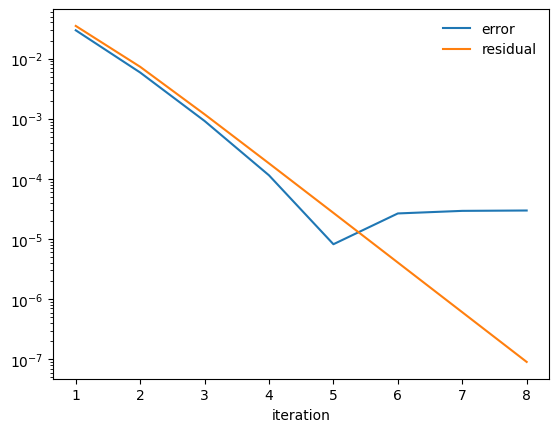

In [13]:
from pySDC.helpers.stats_helper import get_sorted

error_first_step_storted = get_sorted(stats, sortby='iter', type='e_global_post_iteration', time=1)
residual_first_step_storted = get_sorted(stats, sortby='iter', type='residual_post_iteration', time=0)

import matplotlib.pyplot as plt

plt.plot([me[0] for me in error_first_step_storted], [me[1] for me in error_first_step_storted], label='error')
plt.plot([me[0] for me in residual_first_step_storted], [me[1] for me in residual_first_step_storted], label='residual')
plt.xlabel('iteration')
plt.yscale('log')
plt.legend(frameon=False)
plt.show()

Ups! The residual continues to go down, but the error does not.
Seems we solved the collocation problem unnecessary accurately.
The collocation problem is the discretization in time.
Try increasing the number of collocation nodes or reducing the step size to increase the temporal resolution and achieving lower error.
Once more we see that pySDC allows to collect vast amounts of data and perform detailed analysis.

Finally, let's check about the caching of solvers.
Looking at the timings, we should see that the first step takes much longer than subsequent ones.

In [14]:
timings = get_sorted(stats, type='timing_step')
print(f'Took {timings[0][1]:.2e}s for the first step and {timings[1][1]:.3e}s for the second step')

Took 6.88e-01s for the first step and 3.319e-01s for the second step


## Using pySDC as an integrator within another library
Once you have coupled a datatype to pySDC, you can implement pySDC as an integrator for libraries building on the same datatype.
For instance, we have implemented this for [Gusto](https://www.firedrakeproject.org/gusto/), which builds on Firedrake to assemble dynamical cores as used in numerical weather prediction.
The way you go about this is to look at the interface for other integrators in the library you want to couple to.
Chances are an integrator accepts some initial conditions and returns the solution at the end of the interval.
In this case, you need to assemble a pySDC controller to do what you want and then, in the library you want to couple to, pass the solution between pySDC and the library.
In code, this looks approximataly like so:

```
class pySDC_integrator(my_library_integrator):

    def __init__(self, description):
        super().__init__()
        self.controller = controller_nonMPI(description, ...)

    def integrate(u0, dt, t):
        P = self.controller.MS[0].levels[0].prob
        _u = P.u_init(u0)
        u_end, _ = self.controller.run(u0=_u, t0=t, Tend=t+dt)
        return uend.as_my_library_dtype()
```

Of course, you need to take care that `dt` is divisible by the pySDC time step and so on.
Also, you need to implement the coupling in a problem class.
That is to say, you need an interface that can be called by pySDC and which calls the respective functions for evaluating and inverting $f$ in the library you want to couple to.
Since the library may not be designed to be used like this, this may cause some issues.
But if the library you want to couple to is well coded, it should be feasible to use pySDC as an integrator within this library.

## Summary
In this notebook you saw how to couple pySDC with another library, in this case Firedrake.
The main part of this is to write a datatype that connects the interfaces of pySDC and the library.
Then, we implemented the heat equation to be integrated in time with pySDC and discretized in space with Firedrake.
The problem classes add a little pySDC-specific infrastructure, but they are only as difficult to write as it is to use the library you are coupling to.
Once the data type and problem implementations are done, you can readily plug this into pySDC and enjoy access to all sorts of SDC-related things.